In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
# from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 


from wrangle import wrangle_data
from model import get_baseline_table, evaluate, append_eval_df, get_eval_df

In [2]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(yhat_df, target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [3]:
get_baseline_table()

,model_type,target_var,rmse
0,simple_avg,fmr,181.0
1,simple_avg,mmr,322.0
2,simple_avg,diff,170.0
3,simple_avg,percent_diff,13.0
4,1_month_rolling_average,fmr,82.0
5,1_month_rolling_average,mmr,34.0
6,1_month_rolling_average,diff,86.0
7,1_month_rolling_average,percent_diff,8.0
8,6_month_rolling_avg,fmr,88.0
9,6_month_rolling_avg,mmr,51.0


In [4]:
df, train, test = wrangle_data()

### Holt-Winters

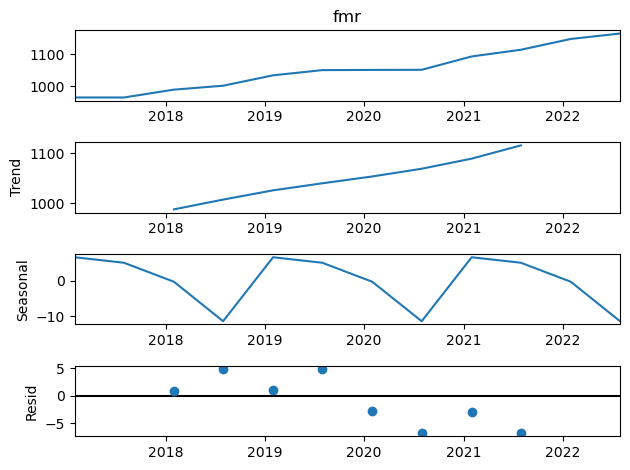

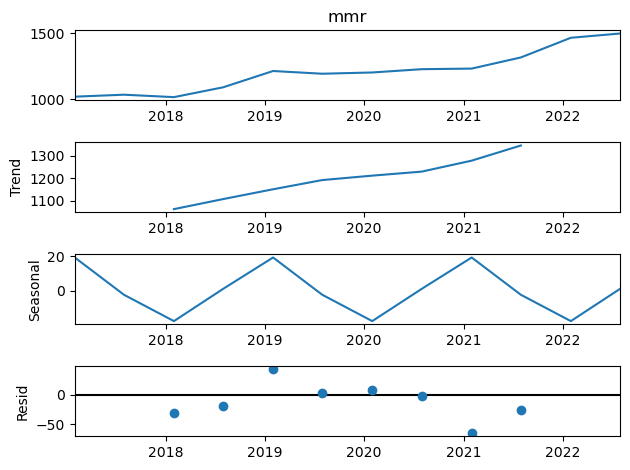

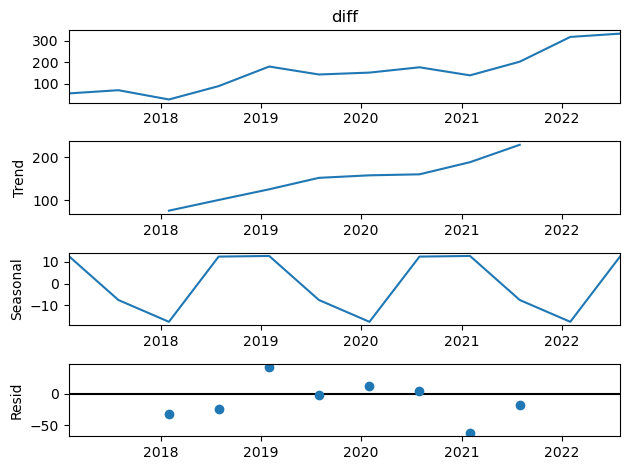

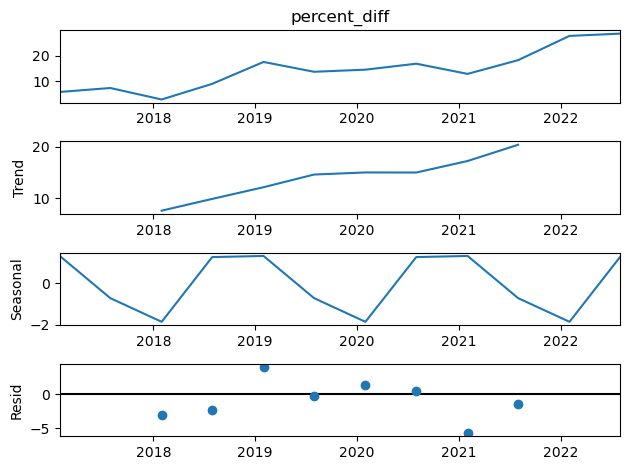

In [5]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('6M').mean()).plot()

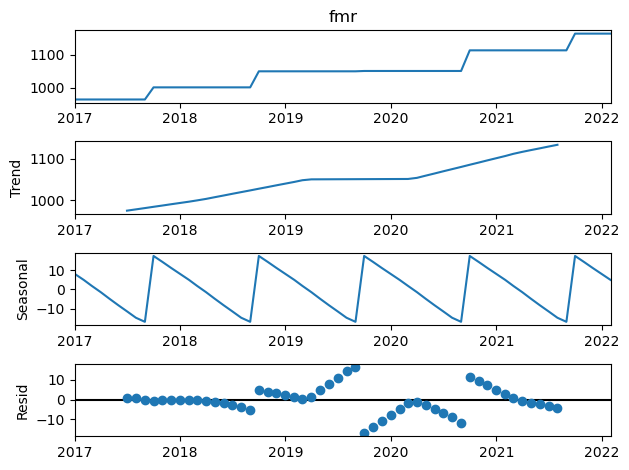

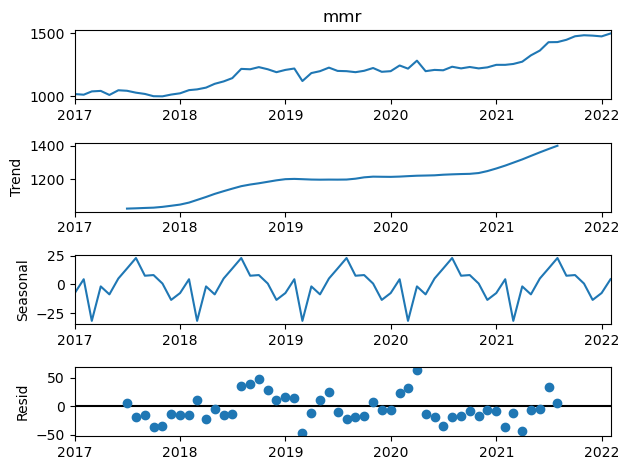

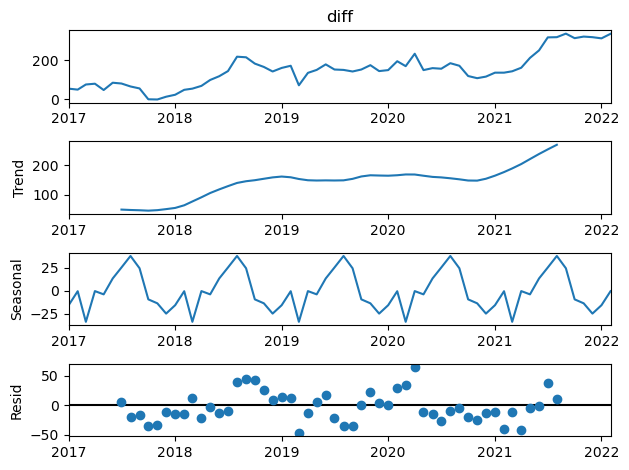

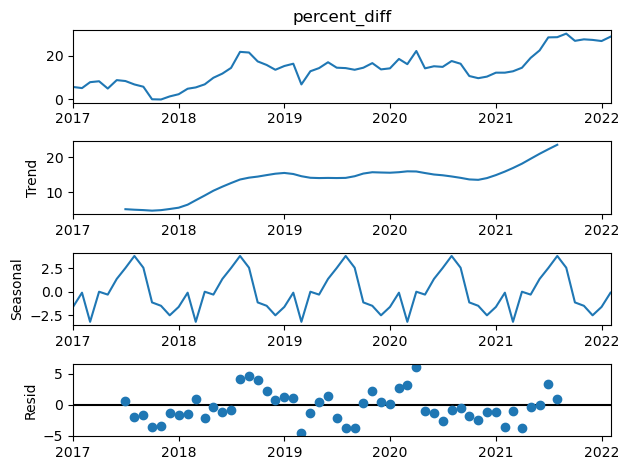

In [6]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col]).plot()

#### Takeaways:
* There is a clear seasonality with all features, with the diff an percent diff looking very expectedly similar
* There is also a clear upward trend thats is apparent

In [7]:
yhat_df = pd.DataFrame(index=test.index)

In [8]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = test.index[0],
                              end = test.index[-1])
    yhat_df[col] = round(yhat_values, 2)


In [9]:
yhat_df.head()

,fmr,mmr,diff,percent_diff
2022-03-01,1167.96,1501.83,333.85,28.73
2022-04-01,1170.68,1508.01,336.68,29.03
2022-05-01,1173.38,1514.15,339.47,29.33
2022-06-01,1176.07,1520.25,342.24,29.63
2022-07-01,1178.75,1526.31,344.98,29.93


fmr -- RMSE: 63


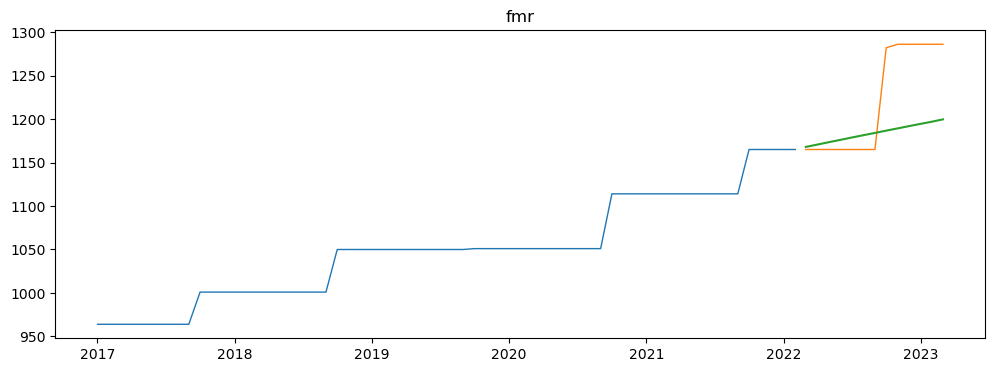

mmr -- RMSE: 43


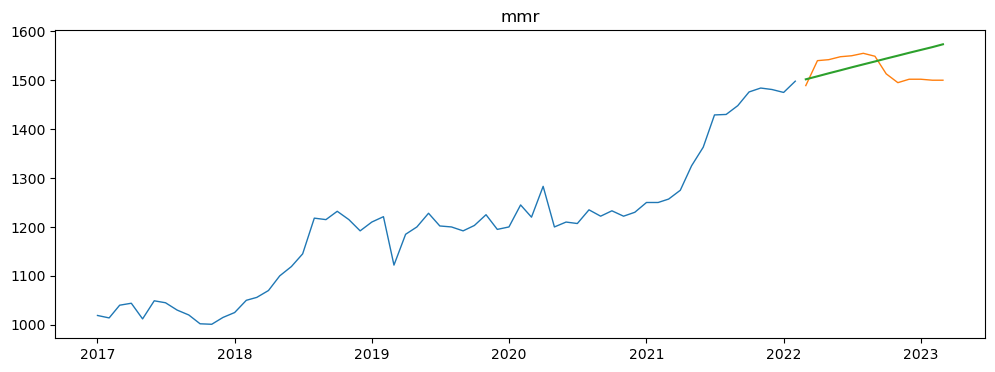

diff -- RMSE: 101


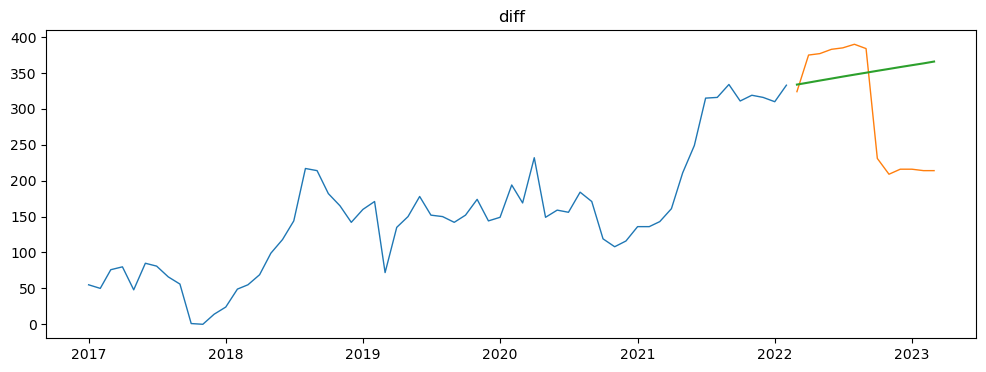

percent_diff -- RMSE: 10


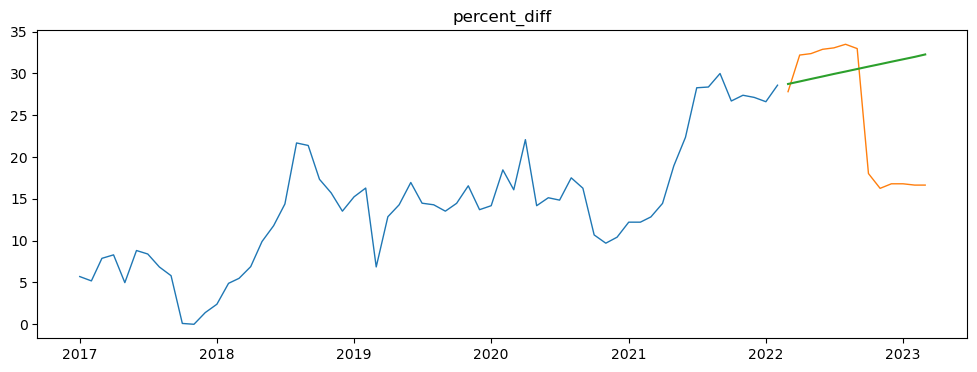

In [10]:
for col in train.columns:
    plot_and_eval(target_var=col)

In [11]:
# get eval df
eval_df = get_eval_df()

# for each col
for col in train.columns:

    # get the input for the target var
    new_eval_df = append_eval_df(yhat_df, model_type = 'holts_optimized', 
                            target_var = col)
    
    # concat it on the eval_df
    eval_df = pd.concat([eval_df, new_eval_df])

In [12]:
get_baseline_table()

,model_type,target_var,rmse
0,simple_avg,fmr,181.0
1,simple_avg,mmr,322.0
2,simple_avg,diff,170.0
3,simple_avg,percent_diff,13.0
4,1_month_rolling_average,fmr,82.0
5,1_month_rolling_average,mmr,34.0
6,1_month_rolling_average,diff,86.0
7,1_month_rolling_average,percent_diff,8.0
8,6_month_rolling_avg,fmr,88.0
9,6_month_rolling_avg,mmr,51.0


In [13]:
eval_df

,model_type,target_var,rmse
0,holts_optimized,fmr,63.0
0,holts_optimized,mmr,43.0
0,holts_optimized,diff,101.0
0,holts_optimized,percent_diff,10.0


#### Takeaway:
* For a basic holts_optimized model, **mmr** out performs the baseline, all others do not outperform the baseline

In [14]:
# function
def get_holts_optimized():
    '''
    This functions models and predicts each column in the global train variable and places the predicted values in a df
    '''
    # intialize df
    d = pd.DataFrame(index=test.index)

    # for each column in train
    for col in train.columns:

        # initialize a model for the column
        model = Holt(train[col], exponential=False, damped=True)

        # fit the model with optimizaiton 
        model = model.fit(optimized=True)

        # get the predicted values, using the first date in the test index and th last date in the index as start and end positions
        values = model.predict(start = test.index[0],
                                  end = test.index[-1])

        # add the values to the dataframe
        d[col] = round(values, 2)

    # exit the function and return the df
    return d

In [15]:
# get_holts_optimized()
# success

## Holt's Seasonal Trend
* Seasonal Periods
    * The seasonal period is one year for all features based on the decomposition plots
* Trend
    * The trend appears to be additive
* Seasonal
    * I believe it is additive

In [16]:
# initial
hst_fit1 = ExponentialSmoothing(train['diff'], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(optimized=True)

yhat_df = pd.DataFrame({'diff': hst_fit1.forecast(test.shape[0] + 1)},
                          index=test.index)
yhat_df

,diff
2022-03-01,314.160047
2022-04-01,345.510811
2022-05-01,340.454693
2022-06-01,365.961583
2022-07-01,376.741618
2022-08-01,392.824826
2022-09-01,388.827348
2022-10-01,357.699874
2022-11-01,357.028051
2022-12-01,349.409583


diff -- RMSE: 98


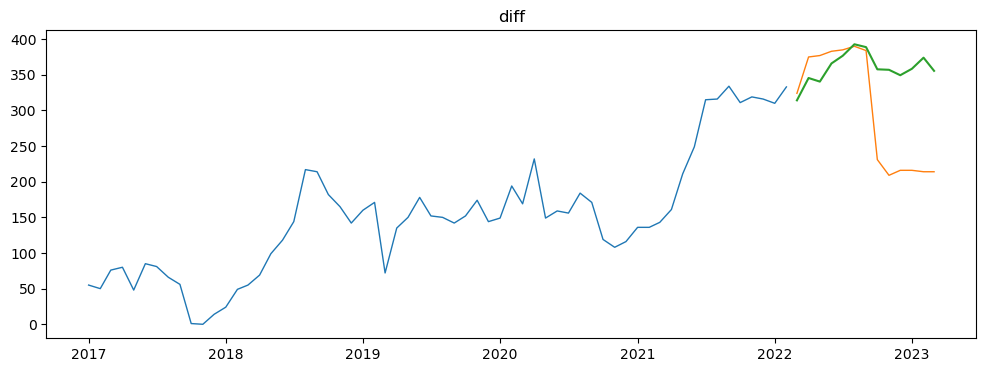

In [17]:
plot_and_eval('diff')

In [18]:
# make programmatic
def get_holt_seasonal_trend_forecast(seasonal_periods=12, trend='add', seasonal='add', damped=True):
    '''
    This function takes in hyperparameteers for the holts seasonal trend model and outputs a df with each forecast for each column in the train df
    '''
    # initialize dictionary
    d = pd.DataFrame(index = test.index)

    # for each column in train
    for col in train.columns:

        # fit on the columns with 12 month seasonality and additive trend and seasonals, with a damped
        hst_fit = ExponentialSmoothing(train[col], seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal, damped=damped).fit(optimized=True)

        # get forecast for the length or shape
        hst_forecast = hst_fit1.forecast(test.shape[0] + 1)

        # add the forecasted information to the dictionary with only the test index
        d[col] = hst_forecast

    # exit function and return the df
    return d

In [19]:
get_holt_seasonal_trend_forecast()

,fmr,mmr,diff,percent_diff
2022-03-01,314.160047,314.160047,314.160047,314.160047
2022-04-01,345.510811,345.510811,345.510811,345.510811
2022-05-01,340.454693,340.454693,340.454693,340.454693
2022-06-01,365.961583,365.961583,365.961583,365.961583
2022-07-01,376.741618,376.741618,376.741618,376.741618
2022-08-01,392.824826,392.824826,392.824826,392.824826
2022-09-01,388.827348,388.827348,388.827348,388.827348
2022-10-01,357.699874,357.699874,357.699874,357.699874
2022-11-01,357.028051,357.028051,357.028051,357.028051
2022-12-01,349.409583,349.409583,349.409583,349.409583


In [24]:
# for col in train.columns:
#     new_eval_df = append_eval_df(yhat_df, model_type = 'holts_seasonal_optimized', 
#                             target_var = col)

#     eval_df = pd.concat([eval_df, new_eval_df])

# eval_df    

# Predict Based on Previous Cycle

In [ ]:
len(test)

In [ ]:
d = (train.loc['2021-02':'2022'] + train.diff(12).mean())

In [ ]:
d.index = test.index

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(d, model_type = 'previous year', target_var = col)


# Get model into model.py

In [23]:
def get_models():
    '''
    This function takes the two best performeing models and presents them in a datframe format
    
    '''
    # get eval_df
    eval_df = get_eval_df()
    
    # Create list of baseline tables with the model name as a pairt
    models_and_type = [(get_holts_optimized(), 'holts_optimized'), (get_holt_seasonal_trend_forecast(), 'holts_seasonal')]

    # for each df and modeltype
    for model, model_type in models_and_type:

        # for each columns in df
        for col in train.columns:

            # add to the eval_df
            new_eval_df = append_eval_df(model, model_type=model_type,
                                    target_var=col)
            
            # concat new eval with old eval
            eval_df = pd.concat([eval_df, new_eval_df])
    
    # exit and return eval df with all evaluations
    return eval_df.reset_index().drop('index', axis=1)


In [25]:
get_models()

,model_type,target_var,rmse
0,holts_optimized,fmr,63.0
1,holts_optimized,mmr,43.0
2,holts_optimized,diff,101.0
3,holts_optimized,percent_diff,10.0
4,holts_seasonal,fmr,863.0
5,holts_seasonal,mmr,1162.0
6,holts_seasonal,diff,98.0
7,holts_seasonal,percent_diff,335.0


In [21]:
get_baseline_table()

,model_type,target_var,rmse
0,simple_avg,fmr,181.0
1,simple_avg,mmr,322.0
2,simple_avg,diff,170.0
3,simple_avg,percent_diff,13.0
4,1_month_rolling_average,fmr,82.0
5,1_month_rolling_average,mmr,34.0
6,1_month_rolling_average,diff,86.0
7,1_month_rolling_average,percent_diff,8.0
8,6_month_rolling_avg,fmr,88.0
9,6_month_rolling_avg,mmr,51.0


In [32]:
def get_all_models():
    '''
    This function returns a df with all models present
    '''
    return pd.concat([get_baseline_table(), get_models()]).reset_index().drop('index', axis=1)

In [33]:
get_all_models()

,model_type,target_var,rmse
0,simple_avg,fmr,181.0
1,simple_avg,mmr,322.0
2,simple_avg,diff,170.0
3,simple_avg,percent_diff,13.0
4,1_month_rolling_average,fmr,82.0
5,1_month_rolling_average,mmr,34.0
6,1_month_rolling_average,diff,86.0
7,1_month_rolling_average,percent_diff,8.0
8,6_month_rolling_avg,fmr,88.0
9,6_month_rolling_avg,mmr,51.0
